# Capstone 2: Part 4. Modeling
## NBA Salary Predictor and Team Optimization
## Austin Cody
#### Models attempted: Lasso Regression, Random Forest Regressor, XGBoost
#### Tuning techniques: GridsearchCV, Bayesian Optimization
#### Team Optimization: Linear Programming - PuLP

## Contents
- [Section 1: Importing, Training, Scaling](#section-1)
- [Section 2: Lasso Regression](#section-2)
- [Section 3: Random Forest Regressor with Bayesian Optimization](#section-3)
- [Section 4: XGBoost with Bayesian Optimization](#section-4)
- [Section 5: Best Model](#section-5)
- [Section 6: Visualizing Best Model Performance](#section-6)
- [Section 7: Linear Programming for Team Optimization](#section-7)
- [Section 8: Optimal NBA Team](#section-8)
- [Section 9: Conclusion](#section-9)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# increasing the number of displayable columns to better examine all dummy variables 
pd.set_option('display.max_columns', 63)
pd.set_option('display.max_rows', 63)

#for replicating results in the future
seed=0

In [2]:
def print_metrics(y_test,y_pred):
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Mean Squared Error: {rmse}')

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')

    r2 = r2_score(y_test, y_pred)
    print(f'R-squared: {r2}')

<a id="section-1"></a>
## Section 1: Importing, Training, Scaling

In [3]:
# reading in csv, splitting data into train/test
df = pd.read_csv('nba_salaries_dummies.csv')
features = ['age','2_pointers_pg','3_pointers_pg','free_throws_pg','assists_pg','points_pg', 'minutes_pg']

X = df[features].values
y = df['salary'].values

# We will do optimization and kfold cross validation on the training set and we don't even touch our test set until the final eval
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)

In [4]:
#scaling from previous notebook
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<a id="section-2"></a>
## Section 2: Lasso Regression

In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

params = {'alpha': [0.01, 0.1, 1.0, 10.0]}
lasso = Lasso(max_iter=100000, random_state=seed)
lasso_gscv = GridSearchCV(lasso, param_grid=params, cv=5, scoring='r2')
lasso_gscv.fit(X_train_scaled,y_train)

best_alpha = lasso_gscv.best_params_['alpha']

best_lasso = Lasso(alpha=best_alpha, max_iter=100000, random_state=seed)
best_lasso.fit(X_train_scaled, y_train)
y_pred_test = best_lasso.predict(X_test_scaled)
y_pred_train = best_lasso.predict(X_train_scaled)

In [6]:
print("Optimal Alpha value for Lasso Regression")
print(best_alpha)

Optimal Alpha value for Lasso Regression
10.0


In [7]:
# Evaluating Lasso Regression model
print("Lasso Regression using best alpha:\n")
print('Train Set:')
print_metrics(y_train,y_pred_train)
print('\nTest Set:')
print_metrics(y_test,y_pred_test)

Lasso Regression using best alpha:

Train Set:
Mean Squared Error: 5879116.104714195
Mean Absolute Error: 4356204.4786811005
R-squared: 0.6734814297753284

Test Set:
Mean Squared Error: 7326576.171920147
Mean Absolute Error: 5210392.541387303
R-squared: 0.6426775993947955


In [8]:
# cross validation
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=4, shuffle=True, random_state=seed)
cv_results = cross_val_score(best_lasso, X, y, cv=kf, scoring='r2')
np.mean(cv_results)

0.6315047382164232

<a id="section-3"></a>
## Section 3: Random Forest Regressor - Bayesian Optimization 

In [9]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, KFold

#optimizes r2 for our random forest regressor
def rfr_objective_function(n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                max_depth=int(max_depth),
                                min_samples_split=int(min_samples_split),
                                min_samples_leaf=int(min_samples_leaf),
                                max_features=int(max_features),
                                max_leaf_nodes=int(max_leaf_nodes),
                                random_state=seed)

    # cross validating inside our objective functions avoids overfitting to our individual set of data
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_scores = cross_val_score(rfr, X_train_scaled, y_train, cv=kf, scoring='r2')

    return np.mean(cv_scores)

rfr_bo = BayesianOptimization(f = rfr_objective_function,
                              pbounds = {'n_estimators':(10,500),
                                           'max_depth':(3,10),
                                           'min_samples_split':(2,10),
                                           'min_samples_leaf':(1,10),
                                           'max_features':(3,len(features)),
                                           'max_leaf_nodes':(2,30)},
                              random_state=seed)

rfr_bo.maximize(n_iter=15, init_points=5)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7096    | 6.842     | 5.861     | 18.88     | 5.904     | 5.389     | 326.5     |
| 2         | 0.7209    | 6.063     | 6.567     | 28.98     | 4.451     | 8.334     | 269.2     |
| 3         | 0.5885    | 6.976     | 6.702     | 3.989     | 1.784     | 2.162     | 418.0     |
| 4         | 0.6733    | 8.447     | 6.48      | 29.4      | 8.192     | 5.692     | 392.5     |
| 5         | 0.6367    | 3.828     | 5.56      | 6.014     | 9.502     | 6.175     | 213.2     |
| 6         | 0.7209    | 6.384     | 6.525     | 27.66     | 3.444     | 6.86      | 268.0     |
| 7         | 0.4048    | 8.457     | 5.357     | 2.49      | 9.921     | 7.659     | 288.4     |
| 8         | 0.6297    | 3.0       | 7.0       | 30.0      | 10.0      | 10.0      | 250.1     |
| 9         | 0.7134

In [10]:
print("Optimal Parameters for Random Forest Regressor")
for key, value in rfr_bo.max['params'].items():
    print("{}: {}".format(key,value))

Optimal Parameters for Random Forest Regressor
max_depth: 10.0
max_features: 7.0
max_leaf_nodes: 16.53141628641396
min_samples_leaf: 1.0
min_samples_split: 2.0
n_estimators: 314.0447514189265


In [11]:
rfr_optimized = RandomForestRegressor(max_depth = int(rfr_bo.max['params']['max_depth']),
                                      max_features = int(rfr_bo.max['params']['max_features']),
                                      max_leaf_nodes = int(rfr_bo.max['params']['max_leaf_nodes']),
                                      min_samples_leaf = int(rfr_bo.max['params']['min_samples_leaf']),
                                      min_samples_split = int(rfr_bo.max['params']['min_samples_split']),
                                      n_estimators = int(rfr_bo.max['params']['n_estimators']),
                                      random_state=seed)
rfr_optimized.fit(X_train_scaled,y_train)
y_pred_test = rfr_optimized.predict(X_test_scaled)
y_pred_train = rfr_optimized.predict(X_train_scaled)

# Evaluating Best Random Forest Regressor
print("Bayesian Optimized Random Forest Regressor:\n")
print('Train Set:')
print_metrics(y_train,y_pred_train)
print('\nTest Set:')
print_metrics(y_test,y_pred_test)

Bayesian Optimized Random Forest Regressor:

Train Set:
Mean Squared Error: 3287686.760727622
Mean Absolute Error: 2452673.0601345347
R-squared: 0.8978908460713678

Test Set:
Mean Squared Error: 6568824.866478864
Mean Absolute Error: 4388075.26675387
R-squared: 0.7127675709120058


In [12]:
#cross validation using the optimized random forest regressor
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=4, shuffle=True, random_state=seed)
cv_results = cross_val_score(rfr_optimized, X, y, cv=kf, scoring='r2')
np.mean(cv_results)

0.7219108271180742

<a id="section-4"></a>
## Section 4: XGBoost - Bayesian Optimization 

In [13]:
from xgboost import XGBRegressor

#optimizes rmse for our linear model
def xgb_objective_function(learning_rate,max_depth,subsample,colsample_bytree,reg_lambda,reg_alpha):
    # instantiating xgbregressor
    xgb = XGBRegressor(objective='reg:squarederror',
                       learning_rate=learning_rate, 
                       max_depth=int(max_depth), 
                       subsample=subsample, 
                       colsample_bytree=colsample_bytree,
                       reg_lambda=reg_lambda, 
                       reg_alpha=reg_alpha,
                       random_state=seed)

    # cross validating inside our objective functions avoids overfitting to our individual set of data
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_scores = cross_val_score(xgb, X_train_scaled, y_train, cv=kf, scoring='r2')

    return np.mean(cv_scores)

xgb_bo = BayesianOptimization(f = xgb_objective_function,
                              pbounds = {'learning_rate':(0.01,0.3),
                                           'max_depth':(3,10), 
                                           'subsample':(0.1,1.0),
                                           'colsample_bytree':(0.1,1.0),
                                           'reg_lambda':(0.01,10),
                                           'reg_alpha':(0.01,10)},
                              random_state=seed)

xgb_bo.maximize(n_iter=15, init_points=5)

|   iter    |  target   | colsam... | learni... | max_depth | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.6769    | 0.5939    | 0.2174    | 7.219     | 5.453     | 4.242     | 0.6813    |
| 2         | 0.709     | 0.4938    | 0.2686    | 9.746     | 3.841     | 7.919     | 0.576     |
| 3         | 0.6664    | 0.6112    | 0.2784    | 3.497     | 0.8804    | 0.212     | 0.8494    |
| 4         | 0.6922    | 0.8003    | 0.2623    | 9.85      | 7.994     | 4.62      | 0.8025    |
| 5         | 0.555     | 0.2064    | 0.1956    | 4.003     | 9.447     | 5.223     | 0.4732    |
| 6         | 0.6722    | 1.0       | 0.3       | 10.0      | 2.011     | 4.647     | 1.0       |
| 7         | 0.5072    | 1.0       | 0.01      | 10.0      | 7.004     | 9.72      | 1.0       |
| 8         | 0.5073    | 0.6453    | 0.01374   | 7.308     | 4.136     | 9.917     | 0.4818    |
| 9         | 0.5874

In [14]:
print("Optimal Parameters for XGBRegressor")
for key, value in xgb_bo.max['params'].items():
    print("{}: {}".format(key,value))

Optimal Parameters for XGBRegressor
colsample_bytree: 0.49382849013642327
learning_rate: 0.2686141702268031
max_depth: 9.745639323507206
reg_alpha: 3.840580773069519
reg_lambda: 7.919333130445819
subsample: 0.5760054277776141


In [15]:
# using the best hyperparameters when creating our XGBRegressor object
xgb_optimized = XGBRegressor(learning_rate = xgb_bo.max['params']['learning_rate'],
                             max_depth = int(xgb_bo.max['params']['max_depth']),
                             subsample = xgb_bo.max['params']['subsample'],
                             colsample_bytree = xgb_bo.max['params']['colsample_bytree'],
                             reg_lambda = xgb_bo.max['params']['reg_lambda'],
                             reg_alpha = xgb_bo.max['params']['reg_alpha'], 
                             random_state=seed)
xgb_optimized.fit(X_train_scaled,y_train)
y_pred_test = xgb_optimized.predict(X_test_scaled)
y_pred_train = xgb_optimized.predict(X_train_scaled)

# Evaluating Best XGBoost Model
print("Bayesian Optimized XGBoost:\n")
print('Train Set:')
print_metrics(y_train,y_pred_train)
print('\nTest Set:')
print_metrics(y_test,y_pred_test)

Bayesian Optimized XGBoost:

Train Set:
Mean Squared Error: 535389.6854691582
Mean Absolute Error: 279432.16928003536
R-squared: 0.9972921549316804

Test Set:
Mean Squared Error: 7184854.087420477
Mean Absolute Error: 4946402.668417009
R-squared: 0.6563676752700799


In [16]:
#cross validation using the optimized xgbregressor
kf = KFold(n_splits=4, shuffle=True, random_state=seed)
cv_results = cross_val_score(xgb_optimized, X, y, cv=kf, scoring='r2')
np.mean(cv_results)

0.6667864610301267

<a id="section-5"></a>
## Section 5: Best Model
Our Bayesian optimized XGBoost and Random Forest Regressor models seemed to be the strongest and were very similar in performance. Our Random Forest model performs better. The XGBoost in particular massively overfits.

<a id="section-6"></a>
## Section 6: Visualizing Best Model Performance
Determining which players in the NBA are most overvalued and undervalued.

In [17]:
# Creating columns for predicted salary and salary prediction error
X = df[features].values
X_scaled = scaler.transform(X)
salary_predictions_all = rfr_optimized.predict(X_scaled)
df.loc[:,'salary_predicted'] = [int(salary) for salary in salary_predictions_all]
df.loc[:,'salary_prediction_error'] = df['salary'] - df['salary_predicted']

# Viewing most undervalued players
df[['name','salary','salary_predicted','salary_prediction_error']].sort_values('salary_prediction_error',ascending=True).head()

,name,salary,salary_predicted,salary_prediction_error
301,Desmond Bane,2130240,24167265,-22037025
378,Kris Dunn,1000001,21623825,-20623824
96,Kyle Kuzma,13000000,24864985,-11864985
94,Jordan Clarkson,13340000,24433312,-11093312
299,Damion Lee,2133278,12236745,-10103467


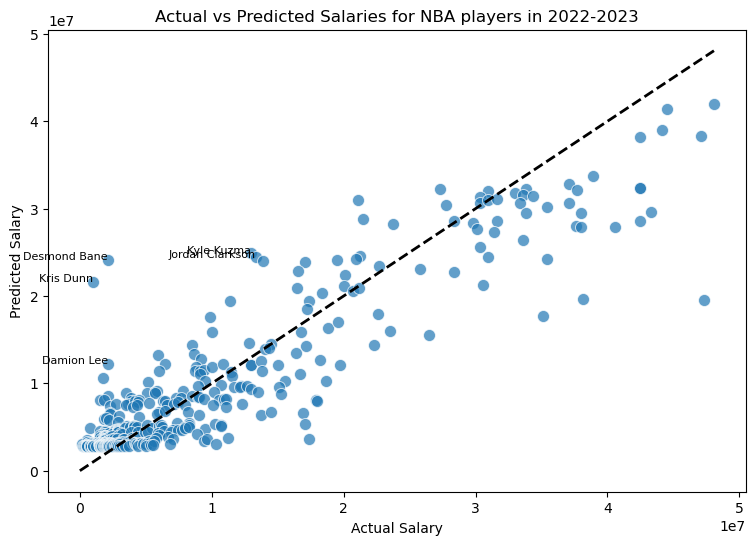

In [18]:
# Visualizing Performance by plotting actual vs predicted salaries
plt.figure(figsize=(9, 6))
scat_plot = sns.scatterplot(x='salary', 
                            y='salary_predicted', 
                            data=df.sort_values('salary_prediction_error',ascending=True),
                            hue=None,
                            s=75,
                            alpha=0.7,
                            legend=False)

# Annotate each point with the player's name BUT just the top 10 most under valued so it doesn't look too chaotic
for index, row in df.sort_values('salary_prediction_error',ascending=True).head(5).iterrows():
    scat_plot.text(row['salary'], row['salary_predicted'], row['name'], fontsize=8, ha='right')

# diagonal line for reference line is perfect predictions
plt.plot([0, df['salary'].max()],
         [0, df['salary'].max()], 
         'k--',
         linewidth=2)

plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salaries for NBA players in 2022-2023')

plt.show()

# The named players below are the most undervalued players in the NBA

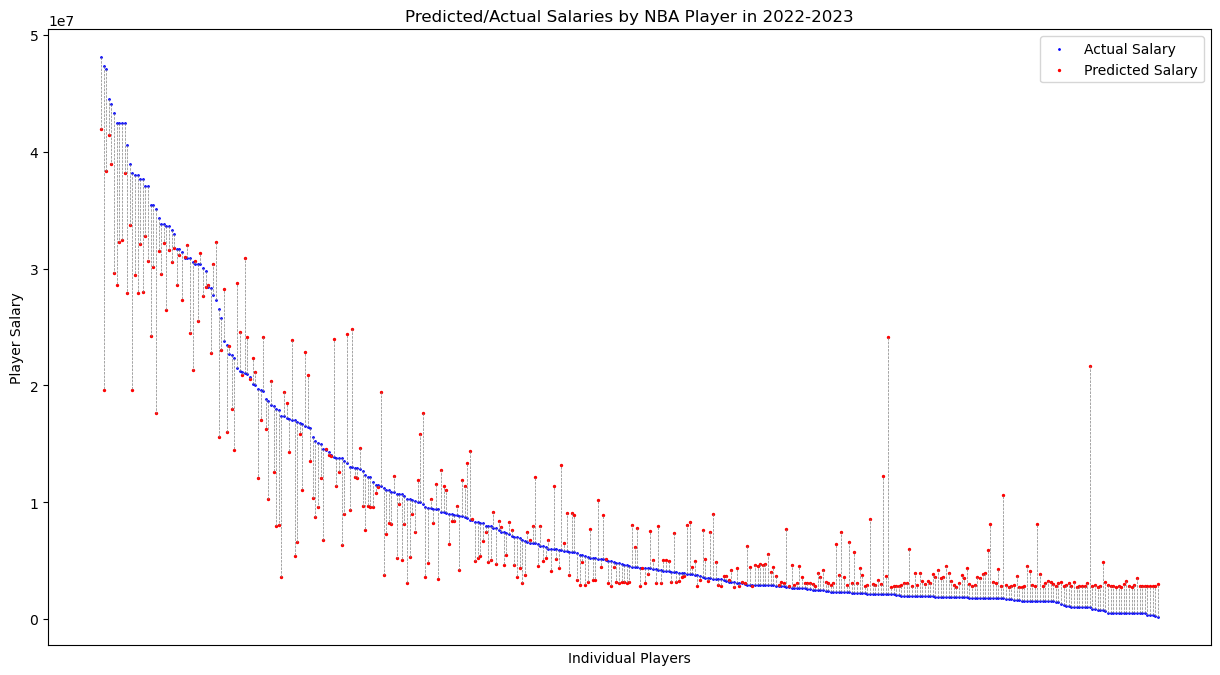

In [19]:
# Visualizing actual and Predicted Salaries by individual player
plt.figure(figsize=(15, 8))

plt.scatter(df['name'], df['salary'], color='blue', label='Actual Salary',s=1)
plt.scatter(df['name'], df['salary_predicted'], color='red', label= 'Predicted Salary',s=2)

for i in range(len(df)):
    plt.plot([df.iloc[i]['name'], df.iloc[i]['name']],
             [df.iloc[i]['salary'], df.iloc[i]['salary_predicted']],
             color='gray', linestyle='--',linewidth=0.5)

plt.title('Predicted/Actual Salaries by NBA Player in 2022-2023')
plt.legend()
plt.xlabel('Individual Players')
plt.ylabel('Player Salary')
plt.xticks([])
plt.show()

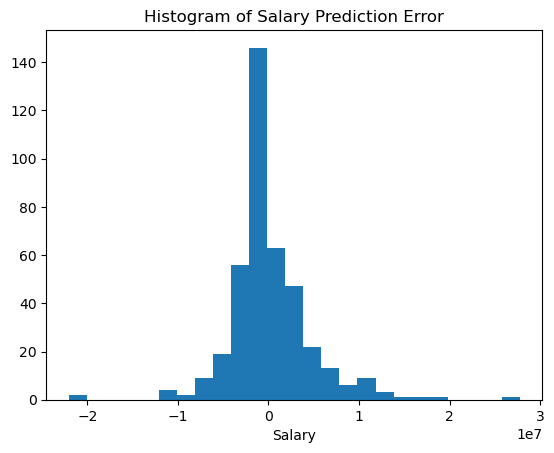

In [20]:
# Visualizing salary prediction error
plt.hist(df['salary_prediction_error'],bins=25)
plt.title('Histogram of Salary Prediction Error')
plt.xlabel('Salary')
plt.show()

<a id="section-7"></a>
# Section 7: Linear Programming for Optimizing team

In [21]:
from pulp import *

players = [player for player in df['name']]

salaries_actual = {key:value for (key,value) in zip(players, df['salary'])}
salaries_pred = {key:value for (key,value) in zip(players, df['salary_predicted'])}
salary_pred_error = {key:value for (key,value) in zip(players, df['salary_prediction_error'])}

position_c = {key:value for (key,value) in zip(players, df['position_C'])}
position_pg = {key:value for (key,value) in zip(players, df['position_PG'])}
position_sg = {key:value for (key,value) in zip(players, df['position_SG'])}
position_pf = {key:value for (key,value) in zip(players, df['position_PF'])}
position_sf = {key:value for (key,value) in zip(players, df['position_SF'])}

budget = 136021000 # 2023-2024 salary cap for NBA teams
num_players = 15 # standard number of players allowed on an NBA roster without employing two-way contracts
min_per_position = 2 # a team usually won't have fewer than 2 players per position for rotation and injury security

# Instantiating model
prob = LpProblem(name='Team_Optimization', sense=LpMinimize)

# Create binary decision variables for player selection
x = {player: LpVariable(name="x_{}".format(player), cat='Binary') for player in players}

# Objective function: minimize salary prediction error - if you add an expression to prob then it becomes the objective function
# Trying to minimize the total salary prediction error should mean our team has cheaper players with higher stats
prob += lpSum(salary_pred_error[player] * x[player] for player in players), "Prediction_Error"

# Budget constraint - if you add a boolean like here then it becomes a constraint
# Here we use actual salary because that's what we know the player to actually cost (though we know their value to be higher)
prob += lpSum(salaries_actual[player] * x[player] for player in players) <= budget, "Budget_Constraint"

# Position Constraint - you have to multiply by x[player] or else it isn't being affected by the decision variable
prob += lpSum(position_c[player] * x[player] for player in players) >= min_per_position, "Num_C_Constraint"
prob += lpSum(position_pg[player] * x[player] for player in players) >= min_per_position, "Num_PG_Constraint"
prob += lpSum(position_sg[player] * x[player] for player in players) >= min_per_position, "Num_SG_Constraint"
prob += lpSum(position_pf[player] * x[player] for player in players) >= min_per_position, "Num_PF_Constraint"
prob += lpSum(position_sf[player] * x[player] for player in players) >= min_per_position, "Num_SF_Constraint"

# Total players to select constraint
# This works because our players' presence in the roster is represented as 0 or 1 --> so summing them up works
prob += lpSum(x[player] for player in players) == num_players, "Num_Players_Constraint"

# Solve the linear programming problem
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/austincody/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/kz/h6tx1dl148q0y2gy6nyf4m100000gn/T/e22211cdf2c34197896ec904c62b710c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/kz/h6tx1dl148q0y2gy6nyf4m100000gn/T/e22211cdf2c34197896ec904c62b710c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 2450 RHS
At line 2458 BOUNDS
At line 2864 ENDATA
Problem MODEL has 7 rows, 405 columns and 1222 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -1.54634e+08 - 0.00 seconds
Cgl0004I processed model has 7 rows, 405 columns (405 integer (405 of which binary)) and 1222 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.233135
Cbc0038I Pass   1: suminf.    0.16756 (2) obj. -1.543e+08 iterations 3
Cbc0038I

1

<a id="section-8"></a>
# Section 8: Optimal NBA Team

In [22]:
#Viewing results
#print("Status:", LpStatus[prob.status])

print("Optimal NBA Team:")

# Tracking how many of each position we acquired
count_c = 0 
count_pg = 0
count_sg = 0
count_pf = 0
count_sf = 0

for player in players:
    
    if value(x[player]) == 1:
        print(f"Player:        {player}")
        
        position = []
        if position_c[player]:
            position.append("Center")
            count_c += 1
        elif position_pg[player]:
            position.append("Point Guard")
            count_pg += 1
        elif position_sg[player]:
            position.append("Shooting Guard")
            count_sg += 1
        elif position_pf[player]:
            position.append("Power Forward")
            count_pf += 1
        elif position_sf[player]:
            position.append("Small Forward")
            count_sf += 1
        position = "/".join(position)
        
        print(f"Position:      {position}")
        print(f"Actual Salary: {salaries_actual[player]}")
        print(f"Pred Salary:   {salaries_pred[player]}\n")
        
print("Total Prediction Error:  ", int(value(prob.objective)))

total_salary = sum(value(x[player]) * salaries_actual[player] for player in players)
print("Total Spent on Salaries: ", int(total_salary))
print("Budget:                  ", budget)
if total_salary > budget:
    print("ERROR: Budget Constraint Not Satisfied")

print("Number of Centers:        ",count_c)
print("Number of Point Guards:   ",count_pg)
print("Number of Shooting Guards:",count_sg)
print("Number of Power Forwards: ",count_pf)
print("Number of Small Forwards: ",count_sf)

counts = [count_c,count_pg,count_sg,count_pf,count_sf]
for count in counts:
    if count < min_per_position:
        print("ERROR: Position Constraints Not Satisfied")

Optimal NBA Team:
Player:        Terry Rozier
Position:      Shooting Guard
Actual Salary: 21486316
Pred Salary:   28793180

Player:        Domantas Sabonis
Position:      Center
Actual Salary: 21100000
Pred Salary:   30931772

Player:        Brook Lopez
Position:      Center
Actual Salary: 13906976
Pred Salary:   23994877

Player:        Jordan Clarkson
Position:      Shooting Guard
Actual Salary: 13340000
Pred Salary:   24433312

Player:        Kyle Kuzma
Position:      Power Forward
Actual Salary: 13000000
Pred Salary:   24864985

Player:        Dillon Brooks
Position:      Small Forward
Actual Salary: 11400000
Pred Salary:   19422560

Player:        De'Andre Hunter
Position:      Small Forward
Actual Salary: 9835881
Pred Salary:   17602881

Player:        Cameron Johnson
Position:      Power Forward
Actual Salary: 5887899
Pred Salary:   13228451

Player:        Jaden McDaniels
Position:      Small Forward
Actual Salary: 2161440
Pred Salary:   8579232

Player:        Damion Lee
Posi

<a id="section-9"></a>
# Section 9: Conclusion
Using a Bayesian Optimized Random Forest Regressor and linear programming using PuLP we have identified an optimal NBA team that is undervalued by over 150M and lies within budget and position constraints.